# Burgers Equation PINN

In [28]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [29]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

In [30]:
# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)
Xbc = torch.cat((XL, XR), dim=0)
Ubc = torch.cat((uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [31]:
# Collocation points
N_coll = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1

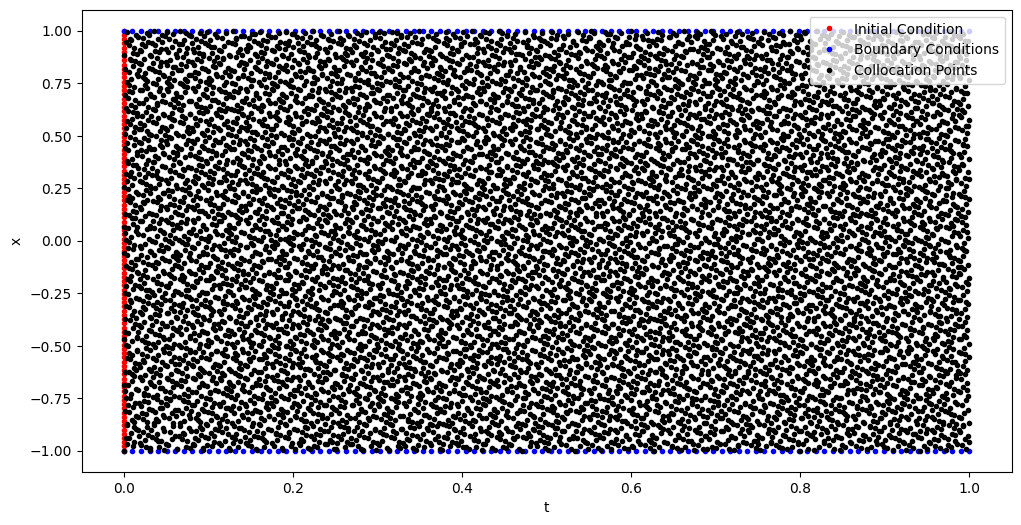

In [32]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Setup Boundary Value Problem

In [ ]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx

### Initialize and train PINN

In [34]:
class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 100000
        D = 2000
        k = 0.5
        c = 0.1

        Xc = sobol.draw(n=N_coll, dtype=torch.float32)
        Xc[:, 1] = Xc[:, 1]*2 - 1
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        residual = abs(self.F(Xc, u) + self.G(torch.cat([Xc, u], dim=1)))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)

In [ ]:
# Define model architectures
hidden = [64] * 3
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)
G = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=lambda x: torch.zeros_like(x),
)

nu = 0.01/torch.pi
F = Burger(nu)

# Instantiate the UPINN
upinn = UPINN(u, F, G, initial_points=(X0, U0), boundary_points=(Xbc, Ubc), collocation_points=Xc)

[Info]: Initializing UPINN model


In [ ]:
for _ in range(50):
    upinn.train_loop(epochs=1000, optimizer=torch.optim.Adam, optimizer_kwargs=dict(lr=1e-3))
    upinn.train_loop(epochs=1000, optimizer=torch.optim.LBFGS, optimizer_kwargs=dict(max_iter=1))
    upinn.refine_collocation_points()

In [37]:
# Save the model
# torch.save(upinn.state_dict(), 'upinn_burger_RAD_100000_Adam_LBFGS')

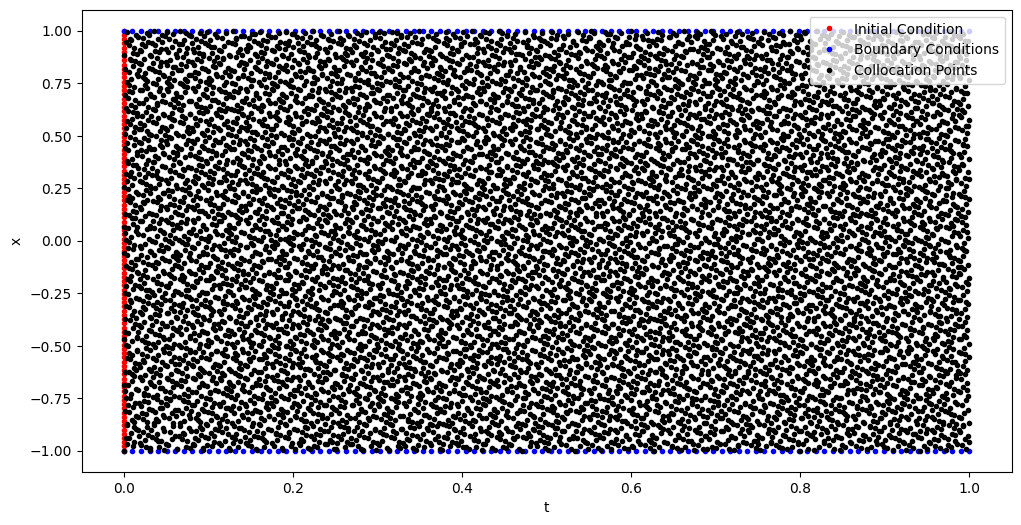

In [39]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(upinn.collocation_points[:, 0].detach(), upinn.collocation_points[:, 1].detach(), 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Plot Results

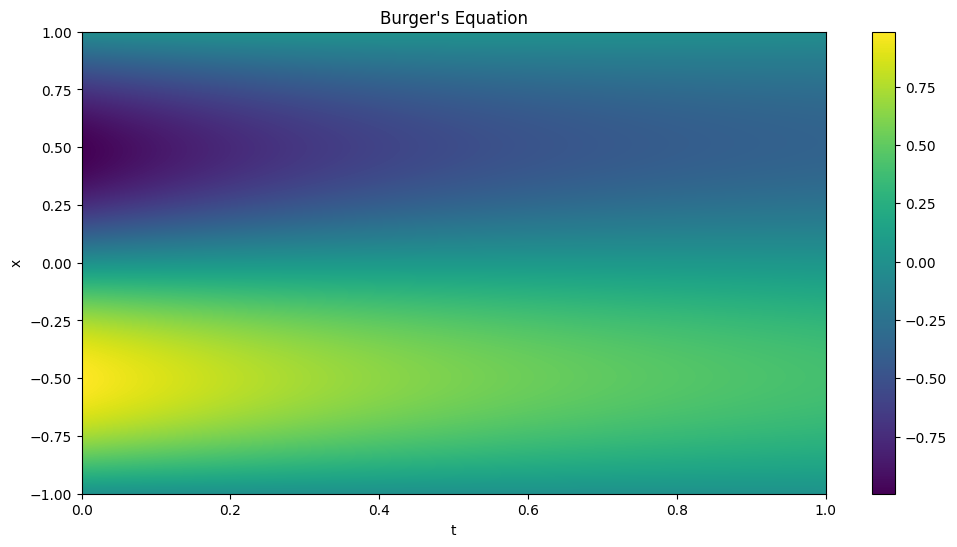

In [40]:
# Make grid
N = 1000
x = torch.linspace(-1, 1, N)
t = torch.linspace(0, 1, N)
X, T = torch.meshgrid(x, t, indexing='ij')
X_star = torch.stack((T.flatten(), X.flatten()), dim=-1)

# Compute the solution
u_star = upinn.predict(X_star)
u = u_star.reshape(N, N).detach().numpy()

# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(u, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burger\'s Equation')
plt.show()

Make a class that can plot the results of the UPINN.

In [41]:
# Function for refining collocation points based on loss

def collocation_refiner(u_hat, pde_func):
    # Use RAD algorithm to refine collocation points
    N = 1000000
    D = 1000

    x = torch.rand(N, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
    t = torch.rand(N, 1, requires_grad=True)
    z = torch.cat([t, x], dim=1)

    # Compute the residual
    u = u_hat(z)
    residual = pde_func(u, z)

    # Sample D points with the largest residual
    residual = residual.detach().numpy()
    
    return z[torch.argsort(residual, descending=True)[:D]]